In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
%cd /alpha/projects/wastie/code/kondrashov/delta/notes/aggregate/finale

/alpha/projects/wastie/code/kondrashov/delta/notes/aggregate/finale


/alpha/projects/wastie/code/kondrashov/delta/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [63]:
# Load config
import json
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import sys
sys.path.append('../../../utils')
sys.path.append('../../..')

In [64]:
IMAGE_SHAPE = (1000, 1000)
CONFIG_PATH = '../../../config.json'
SPLIT = 'test'
IOU_THRESHOLD = 0.7

### Trainval

In [65]:
import pickle
import json
TEST_NAME = 'trainval'
with open(f'/alpha/projects/wastie/code/kondrashov/delta/groups/gt_groups_trainval.pkl', 'rb') as f:
    gt_extended_groups = pickle.load(f)
with open(f'/alpha/projects/wastie/code/kondrashov/delta/groups/pred_groups_trainval.pkl', 'rb') as f:
    pred_extended_groups = pickle.load(f)
with open(f'../../../data/trainval/speed.json') as f:
    speed_dict = json.load(f)
    shifts = {}
    speed_sum = 0
    for k, v in sorted(speed_dict.items(), key=lambda x: x[0]):
        speed_sum += v
        shifts[Path(k).name] = speed_sum

In [66]:
confs = np.array([o['obj']['conf'] for g in pred_extended_groups for o in g])

(array([       5082,        5465,        5683,        6280,        7048,        7971,        9537,       11622,       15368,       21582,       33681,       54989,       62255,       15226,         102]),
 array([    0.54756,     0.57579,     0.60401,     0.63224,     0.66047,      0.6887,     0.71692,     0.74515,     0.77338,     0.80161,     0.82983,     0.85806,     0.88629,     0.91452,     0.94275,     0.97097]),
 <BarContainer object of 15 artists>)

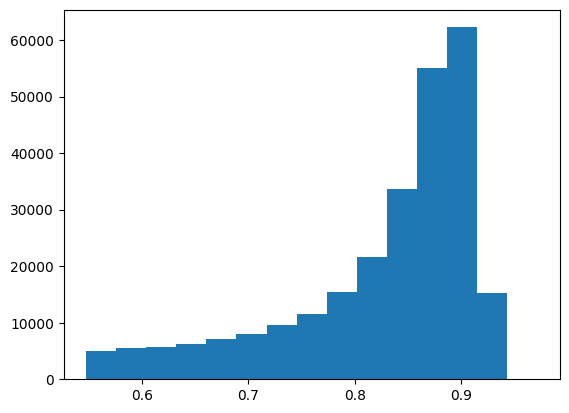

In [67]:
plt.hist(confs, bins=15)

Median group size: 15


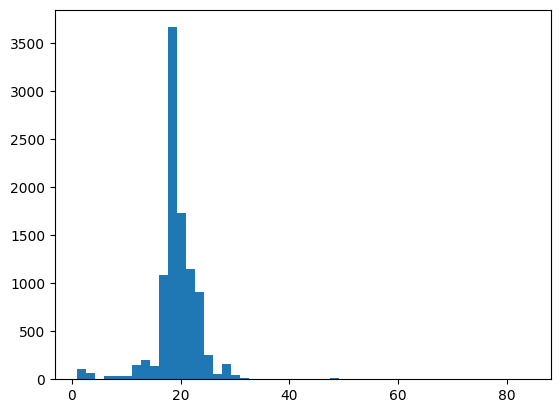

In [68]:
plt.hist([len(g) for g in gt_extended_groups], bins=50)
median_length = int(np.median([len(g) for g in pred_extended_groups]))
print(f"Median group size: {median_length}")

### Получим группы на ленте

In [69]:
from copy import deepcopy
import random
from utils.integrate.integrate import shift_mask
from utils.interpolate.refine_markup_by_yolo import poly, mask_iou, get_box

def align_group(ext_group, shifts):
    ext_group = deepcopy(ext_group)
    for obj in ext_group:
        shift = shifts[obj['img'].name]
        conf = None
        if 'conf' in obj['obj']:
            conf = float(obj['obj']['conf'])
        obj['obj'] = shift_mask(obj['obj'], shift)
        obj['obj']['is_border'] = obj['is_border']
        if conf is not None:
            obj['obj']['conf'] = conf
    return ext_group

def align_groups(ext_group, shifts):
    return [
        align_group(ext_group, shifts)
        for ext_group in ext_group
    ]

In [70]:
gt_aligned_groups = align_groups(gt_extended_groups, shifts)
pred_aligned_groups = align_groups(pred_extended_groups, shifts)

In [71]:
gt_groups = [[o['obj'] for o in g] for g in gt_aligned_groups]
pred_groups = [[o['obj'] for o in g]  for g in pred_aligned_groups]

In [72]:
gt_groups = [g for g in gt_groups if max([get_box(o)[1] > 1500000 for o in g])]
pred_groups = [g for g in pred_groups if max([get_box(o)[1] > 1500000 for o in g])]

In [73]:
print(len(gt_groups), len(pred_groups))

4102 4856


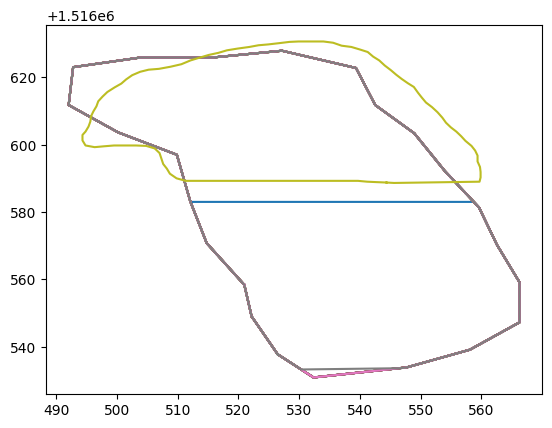

In [74]:
for polygon in map(poly, gt_groups[random.randint(0, len(gt_groups))]):
    x, y = polygon.exterior.xy
    plt.plot(x, y)
plt.show()

### Создадим агрегатор

In [75]:
from src.aggregate.base import Aggregator, ComposeClassifier
from src.aggregate.threshold import ThresholdClassifier
from src.aggregate.noborder import NoBorderClassifier
from src.aggregate.confidence import MaxConfidenceClassifier, ConfidenceClassifier
from src.aggregate.merge import UnionMerger, NMSMerger, SoftNMSMerger

In [76]:
N_CLASSES = 2
INTEGRATE_THRESHOLD = 1
CONFIDENCE_THRESHOLD = 0.9
YOLO_CONF = 0.5

In [77]:
noborder_classifier = NoBorderClassifier(N_CLASSES, IMAGE_SHAPE)
threshold_classifier = ThresholdClassifier(N_CLASSES, INTEGRATE_THRESHOLD)
confidence_classifier = MaxConfidenceClassifier(N_CLASSES, CONFIDENCE_THRESHOLD)
classifier = ComposeClassifier([
    noborder_classifier,
    threshold_classifier,
])
merger = SoftNMSMerger(N_CLASSES, conf_threshold=YOLO_CONF)
aggregator = Aggregator(classifier, merger)

gt_merger = UnionMerger(N_CLASSES)
gt_aggregator = Aggregator(threshold_classifier, gt_merger)

### Агрегация

In [78]:
gt = gt_aggregator.aggregate(gt_groups)
pred = aggregator.aggregate(pred_groups)

In [79]:
len(pred)

4853

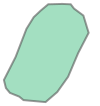

In [80]:
poly(gt[random.randint(0, len(gt))])

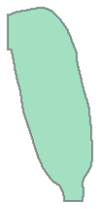

In [81]:
poly(pred[random.randint(0, len(pred))])

In [82]:
# mismatch_set = set(map(int, mismatch_indices))

In [83]:
# np.where(pred_matches2)[0]

In [84]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2, max(shifts.values()) / 1000))

for i, polygon in enumerate(map(poly, gt)):
    x, y = polygon.exterior.xy
    ax1.plot(x, y)
ax1.invert_yaxis()
ax1.set_title('GT')

for i, polygon in enumerate(map(poly, pred)):
    x, y = polygon.exterior.xy
    ax2.plot(x, y)
ax2.invert_yaxis()
ax2.set_title('Prediction')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

xlim = (min(ax.get_xlim()[0] for ax in [ax1, ax2]), max(ax.get_xlim()[1] for ax in [ax1, ax2]))
ylim = (min(ax.get_ylim()[0] for ax in [ax1, ax2]), max(ax.get_ylim()[1] for ax in [ax1, ax2]))

for ax in [ax1, ax2]:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


min_ylim = 0
max_ylim = min(ax.get_ylim()[0] for ax in [ax1, ax2])
for ax in [ax1, ax2]:
    step = 100  # Draw line every 100 pixels
    for y in range(int(min_ylim), int(max_ylim), step):
        ax.axhline(y=y, color='gray', alpha=0.2, linestyle='-')

plt.show()

### Метрики

In [85]:
from tqdm import tqdm 

def boxes_intersect(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Check if one box is to the right of the other
    if x1 + w1 <= x2 or x2 + w2 <= x1:
        return False
        
    # Check if one box is above the other
    if y1 + h1 <= y2 or y2 + h2 <= y1:
        return False
        
    return True

def find_matches(gt : list[dict], pred : list[dict], iou_threshold : float = 0.4):
    gt_boxes = [get_box(t) for t in gt]
    pred_boxes = [get_box(t) for t in pred]

    gt_matches = [False] * len(gt)
    pred_matches = [False] * len(pred)

    for i, gt_obj in tqdm(enumerate(gt), total=len(gt)):
        for j, pred_obj in enumerate(pred):
            if boxes_intersect(gt_boxes[i], pred_boxes[j]):
                iou = mask_iou(gt_obj, pred_obj)
                if iou > iou_threshold:
                    gt_matches[i] = True
                    pred_matches[j] = True
    return np.array(gt_matches), np.array(pred_matches)

In [86]:
import numpy as np
from shapely.strtree import STRtree
from shapely.geometry import Polygon, box
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import multiprocessing as mp

def get_box(points):
    """Вычисление ограничивающего прямоугольника для списка точек"""
    points = np.array(points)
    return [np.min(points[:, 0]), np.min(points[:, 1]), 
            np.max(points[:, 0]), np.max(points[:, 1])]

def mask_iou_from_points(gt_points, pred_points):
    """Вычисление IoU для двух масок по их точкам"""
    gt_poly = Polygon(gt_points)
    pred_poly = Polygon(pred_points)
    
    if not gt_poly.is_valid or not pred_poly.is_valid:
        return 0.0
    
    intersection = gt_poly.intersection(pred_poly).area
    union = gt_poly.union(pred_poly).area
    
    return intersection / union if union > 0 else 0.0

def process_chunk(args):
    """Обработка пакета данных для параллельных вычислений"""
    chunk, iou_threshold = args
    chunk_results = []
    for i, j, gt_points, pred_points in chunk:
        iou = mask_iou_from_points(gt_points, pred_points)
        if iou > iou_threshold:
            chunk_results.append((i, j))
    return chunk_results

def find_matches(gt: list[dict], pred: list[dict], iou_threshold: float = 0.4):
    """Поиск совпадений между GT и предсказанными масками с использованием IoU"""
    # Извлечение точек и вычисление bounding boxes
    gt = [obj for obj in gt if len(obj['points']) > 0]
    pred = [obj for obj in pred if len(obj['points']) > 0]
    gt_points_list = [np.array(obj['points']) for obj in gt]
    pred_points_list = [np.array(obj['points']) for obj in pred]
    
    gt_boxes = [get_box(points) for points in gt_points_list]
    pred_boxes = [get_box(points) for points in pred_points_list]
    
    # Создание геометрий для пространственного индекса
    gt_geoms = [box(*b) for b in gt_boxes]
    pred_geoms = [box(*b) for b in pred_boxes]
    
    # Построение пространственного индекса для быстрого поиска пересечений
    tree = STRtree(pred_geoms)
    pairs_indices = []
    
    # Поиск пересекающихся пар с использованием пространственного индекса
    for i, gt_geom in enumerate(gt_geoms):
        j_indices = tree.query(gt_geom)
        for j in j_indices:
            pairs_indices.append((i, j))
    
    # Подготовка данных для параллельной обработки
    tasks = []
    chunk_size = min(1000, max(1, len(pairs_indices) // (mp.cpu_count() * 4)))
    
    for idx in range(0, len(pairs_indices), chunk_size):
        chunk = []
        for i, j in pairs_indices[idx:idx+chunk_size]:
            chunk.append((
                i, j,
                gt_points_list[i],
                pred_points_list[j]
            ))
        tasks.append((chunk, iou_threshold))
    
    # Параллельное вычисление IoU
    gt_matches = [False] * len(gt)
    pred_matches = [False] * len(pred)
    
    if tasks:
        with ProcessPoolExecutor() as executor:
            results = list(tqdm(
                executor.map(process_chunk, tasks),
                total=len(tasks),
                desc="Processing pairs"
            ))
            
            for chunk_results in results:
                for i, j in chunk_results:
                    gt_matches[i] = True
                    pred_matches[j] = True
    
    return np.array(gt_matches), np.array(pred_matches)

In [87]:
gt_matches, pred_matches = find_matches(gt, pred, IOU_THRESHOLD)

Processing pairs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 262/262 [00:00<00:00, 939.25it/s]


In [88]:
precision = np.mean(pred_matches) if len(pred_matches) > 0 else 0
recall = np.mean(gt_matches) if len(gt_matches) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.7410
Recall: 0.8786
F1 Score: 0.8039


### Оптимальный порог интеграции

In [89]:
def find_best_threshold(gt_aligned_groups, pred_aligned_groups):
    thresholds = np.linspace(0.3, 0.95, 14)
    precisions = []
    recalls    = []
    f1_scores  = []

    for threshold in thresholds:
        classifier = MaxConfidenceClassifier(N_CLASSES, threshold)
        merger = UnionMerger(N_CLASSES)
        aggregator = Aggregator(classifier, merger)
        
        pred = aggregator.aggregate(pred_groups)

        gt_matches, pred_matches = find_matches(gt, pred, IOU_THRESHOLD)

        precision = np.mean(pred_matches) if len(pred_matches) > 0 else 0
        recall = np.mean(gt_matches) if len(gt_matches) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
    plt.plot(thresholds, precisions, marker='s', label='Precision')
    plt.plot(thresholds, recalls, marker='^', label='Recall')
    plt.xlabel('Integration Threshold')
    plt.ylabel('Score')
    plt.title(f'Metrics vs Integration Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

    max_f1 = max(f1_scores)
    max_f1_threshold = thresholds[f1_scores.index(max_f1)]
    print(f"Max F1: {max_f1:.3f} at threshold {max_f1_threshold}")

In [90]:
find_best_threshold(gt_aligned_groups, pred_aligned_groups)

[0.8796179890632629, 0.9265850186347961, 0.9194660186767578, 0.8628770112991333, 0.8979820013046265, 0.9305260181427002, 0.880843997001648, 0.87602698802948, 0.9223999977111816, 0.8166090250015259, 0.8448230028152466, 0.8499130010604858, 0.828233003616333, 0.6508619785308838, 0.6147400140762329, 0.8977370262145996, 0.9180930256843567, 0.9151279926300049, 0.8853179812431335, 0.873557984828949, 0.8960070013999939, 0.8941109776496887, 0.6087989807128906, 0.7526310086250305, 0.91144198179245, 0.883089005947113, 0.8044949769973755, 0.876242995262146, 0.9055799841880798, 0.7167580127716064, 0.8652179837226868, 0.9095960259437561, 0.7250549793243408, 0.8572890162467957, 0.8481810092926025, 0.6625909805297852, 0.7665299773216248, 0.84368497133255, 0.6431800127029419, 0.8539280295372009, 0.8654739856719971, 0.6904199719429016, 0.8622109889984131, 0.9006209969520569, 0.8656700253486633, 0.7215409874916077, 0.9084830284118652, 0.8998330235481262, 0.9008229970932007, 0.9120069742202759, 0.85128098

KeyboardInterrupt: 